In [1]:
from src import Data, myModel
import matplotlib.pyplot as plt
import numpy as np

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### load X-Y samples from block1, and split into train and test sets

In [2]:
data = Data('./data/block1/')
min_list, max_list = data.get_MinMax('./data/block1/raw_data/workspace/sent_geo.tif')
print('have {0} image tiles in totle'.format(len(data.X)))
X_trn, Y_trn = data.get_XY(min_list, max_list, num=500, as_arr=True, random=True)
print('have {0} image tiles in totle'.format(len(data.X)))
# X_trn, X_tst, Y_trn, Y_tst = data.trn_tst_split(test_rate=0.1, random_seed=42)

have 4816 image tiles in totle
randomly loading 500 tiles from 4816 tiles
have 4316 image tiles in totle


#### visualize images and labels

Text(0.5,1,'lithological mappinp')

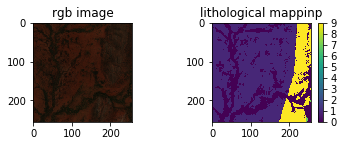

In [3]:
idx = 0
img = X_trn[idx,:,:,:]
lbl = Y_trn[idx,:,:,:]

img_rgb = img[:,:,:3][:,:,::-1]
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('rgb image')
plt.subplot(222)
plt.imshow(np.argmax(lbl, axis=2))
plt.colorbar()
plt.title('lithological mappinp')

#### start to build and train Conv2D

In [4]:
conv = myModel()

# build Conv2D
conv.build_Conv2D(num_bands=23, n_ch_list=[64,64], use_tfboard=True)

# now the tensorboard event file is saved in ./logs
# the training process, graph and statistics can be
# visualize by tensorboard

# compile with loss and optimizer
conv.compile_model(verbose=True)

# build callback for the details of train process
conv.build_callbackList()

building Conv2D ...
[64, 64]
[64]
compiling model ...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 23) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 13312       input_1[0][0]                    
__________________________________________________________________________________________________
alpha_dropout_1 (AlphaDropout)  (None, 256, 256, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       alpha_dropout_1[0][0]            
_______________________________________________________

In [5]:
# load data from last checkpoint
conv.load_checkpoint()
# size_block = 500
# for i in range(8):
#     X_trn, Y_trn = data.get_XY(min_list, max_list, start=i*size_block, num=size_block, as_arr=True)
#     # start to training
#     conv.fit_model(X_trn=X_trn, Y_trn=Y_trn, batch_size=10, num_epochs=1, verbose=1)

Conv2D weights loaded, resuming from epoch 1


In [6]:
conv.fit_model(X_trn=X_trn, Y_trn=Y_trn, batch_size=10, num_epochs=10, verbose=1)

Train on 400 samples, validate on 100 samples
Epoch 2/11
400/400 [==============================] - 718s 2s/step - loss: 2.5247 - acc: 0.3663 - val_loss: 2.7758 - val_acc: 0.3117

Epoch 00002: val_acc improved from -inf to 0.31175, saving model to ./Conv2D/weights-02-0.31.hdf5
Epoch 3/11
400/400 [==============================] - 735s 2s/step - loss: 2.3829 - acc: 0.3741 - val_loss: 2.4451 - val_acc: 0.4434

Epoch 00003: val_acc improved from 0.31175 to 0.44339, saving model to ./Conv2D/weights-03-0.44.hdf5
Epoch 4/11
400/400 [==============================] - 739s 2s/step - loss: 2.2532 - acc: 0.4439 - val_loss: 2.2110 - val_acc: 0.5361

Epoch 00004: val_acc improved from 0.44339 to 0.53607, saving model to ./Conv2D/weights-04-0.54.hdf5
Epoch 5/11
400/400 [==============================] - 744s 2s/step - loss: 2.2672 - acc: 0.4465 - val_loss: 2.6562 - val_acc: 0.4287

Epoch 00005: val_acc did not improve
Epoch 6/11
400/400 [==============================] - 737s 2s/step - loss: 2.2416

KeyboardInterrupt: 

#### predict on test data

In [10]:
# conv.save_weights('./Conv2D/weights-11-.hdf5')
conv.load_weights('./Conv2D/weights-08-0.58.hdf5')

In [7]:
X_tst, Y_tst = data.get_XY(min_list, max_list, num=50, as_arr=True, random=True)
print('have {0} image tiles in totle'.format(len(data.X)))

randomly loading 50 tiles from 4316 tiles
have 4266 image tiles in totle


In [11]:
Y_preds = conv.predict(X_tst=X_tst)

50/50 [==============================] - 33s 661ms/step


#### visualize predicted Y

Text(0.5,1,'prediction')

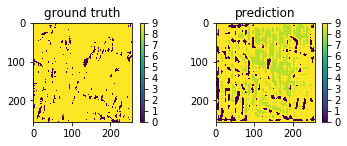

In [22]:
idx = 17
_pred = np.argmax(Y_preds[idx,:,:,:], axis=2)
_tst = np.argmax(Y_tst[idx,:,:,:], axis=2)
plt.subplot(221)
plt.imshow(_tst)
plt.colorbar()
plt.title('ground truth')
plt.subplot(222)
plt.imshow(_pred)
plt.colorbar()
plt.title('prediction')

#### calculate the accuracy

In [13]:
acc_list = []
for i in range(Y_tst.shape[0]):
    tmp_pred = np.argmax(Y_preds[i,:,:,:], axis=2)
    tmp_tst = np.argmax(Y_tst[i,:,:,:], axis=2)
    acc_list.append(np.where(tmp_pred == tmp_tst)[0].shape[0]/(256*256))
print('mean accuracy on test data is {0}, std is {1}'.format(np.mean(acc_list), np.std(acc_list)))
print('max is {0}, min is {1}'.format(max(acc_list), min(acc_list)))

mean accuracy on test data is 0.5567706298828125, std is 0.2908766527222443
max is 0.9994964599609375, min is 0.0458984375


In [28]:
X_trn[19,:,:,0]

array([[4.2800002e-02, 4.1000001e-02, 4.2300001e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [4.2199999e-02, 3.8100000e-02, 4.5899998e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [4.4500001e-02, 3.7400000e-02, 3.9999999e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       ...,
       [4.4199999e-02, 4.6700001e-02, 4.0899999e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [3.9400000e-02, 4.6000000e-02, 4.0899999e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [3.6800001e-02, 4.2599998e-02, 4.6700001e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34]], dtype=float32)

In [40]:
for i in range(len(data.X)):
    tmp = data.img_to_array(data.X[i], min_list=min_list, max_list=max_list)
    if tmp.max() > 1:
        print(i)

92
93
94
191
192
193
194
292
293
294
295


KeyboardInterrupt: 

In [41]:
tmp = data.img_to_array(data.X[92], min_list=min_list, max_list=max_list)

In [44]:
np.where(tmp>1)

(array([  0,   0,   0, ..., 255, 255, 255], dtype=int64),
 array([ 97,  97,  97, ..., 255, 255, 255], dtype=int64),
 array([ 0,  1,  2, ..., 20, 21, 22], dtype=int64))

In [45]:
tmp[0,97,0]

3.4028236e+34

In [46]:
from osgeo import gdal

In [59]:
file = gdal.Open(data.X[92])

In [66]:
aa = file.GetRasterBand(23)

In [52]:
path = './data/block1/sentinel_images/images/000000109.tif'

In [73]:
tmp[tmp>0.1] = 0

In [74]:
tmp

array([[[0.045     , 0.0779    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        [0.0445    , 0.075     , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        [0.0432    , 0.0745    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.0434    , 0.0773    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        [0.0443    , 0.0781    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        [0.0455    , 0.0744    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 